In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"koushalsanjaymodi","key":"08f98bce9fb8eb0c3626fc71db0aa6f7"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats

 97% 789M/812M [00:06<00:00, 109MB/s] 
100% 812M/812M [00:06<00:00, 122MB/s]


In [4]:
!unzip -qq dogs-vs-cats.zip


In [5]:
!unzip -qq train.zip

In [6]:
"""
cats_vs_dogs_small:
train: cats (1000) and dogs (1000)
val: cats (500) and dogs (500)
test: cats (1000) and dogs (1000)
"""

'\ncats_vs_dogs_small:\ntrain: cats (1000) and dogs (1000)\nval: cats (500) and dogs (500)\ntest: cats (1000) and dogs (1000)\n'

In [7]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [8]:
from tensorflow.keras import layers
from tensorflow import keras

In [9]:
inputs = keras.Input(shape = (180,180,3))
x = layers.Rescaling(1./255)(inputs) # scale [0,1] by dividing by 255
x = layers.Conv2D(filters = 32, kernel_size=3, activation = "relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, activation = "relu")(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 128, kernel_size = 3, activation = "relu")(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 256, kernel_size = 3, activation = "relu")(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 256, kernel_size = 3, activation = "relu")(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1, activation = "sigmoid")(x)
model = keras.Model(inputs = inputs, outputs = outputs)

In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(loss = "binary_crossentropy",
              optimizer = "rmsprop",
              metrics = ["accuracy"])

In [13]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size = (180, 180),
    batch_size = 32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size = (180, 180),
    batch_size = 32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size = (180, 180),
    batch_size = 32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [20]:
# understanding TensorFlow Dataset objects
# .batch(), .shuffle(buffer_size), .prefetch(buffer_size), .map(callable)

import numpy as np
import tensorflow as tf

random_numbers = np.random.normal(size = (1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [21]:
for i, element in enumerate(dataset):
  print(element.shape)
  if i >= 2:
    break

(16,)
(16,)
(16,)


In [22]:
batched_dataset = dataset.batch(32)

for i, element in enumerate(batched_dataset):
  print(element.shape)
  if i>= 2:
    break

(32, 16)
(32, 16)
(32, 16)


In [23]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4,4)))
for i, element in enumerate(reshaped_dataset):
  print(element.shape)
  if i >= 2:
    break

(4, 4)
(4, 4)
(4, 4)


In [24]:
for data_batch, labels_batch in train_dataset:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape:", labels_batch.shape)
  break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [25]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "convnet_from_scratch.keras",
        save_best_only = True,
        monitor = "val_loss"
    )
]

history = model.fit(
    train_dataset,
    epochs = 30,
    validation_data = validation_dataset,
    callbacks = callbacks
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - accuracy: 0.4724 - loss: 0.7177 - val_accuracy: 0.5660 - val_loss: 0.6913
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.5232 - loss: 0.6925 - val_accuracy: 0.5740 - val_loss: 0.6773
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.5782 - loss: 0.6884 - val_accuracy: 0.6390 - val_loss: 0.6547
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6159 - loss: 0.6607 - val_accuracy: 0.5460 - val_loss: 0.7061
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.6728 - loss: 0.6094 - val_accuracy: 0.6330 - val_loss: 0.6325
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6744 - loss: 0.5884 - val_accuracy: 0.6530 - val_loss: 0.6302
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.7090 - loss: 0.5491 - val_accuracy: 0.6160 - val_loss: 0.8209
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.7202 - loss: 0.5786 - val_accuracy: 0.6540 

In [29]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

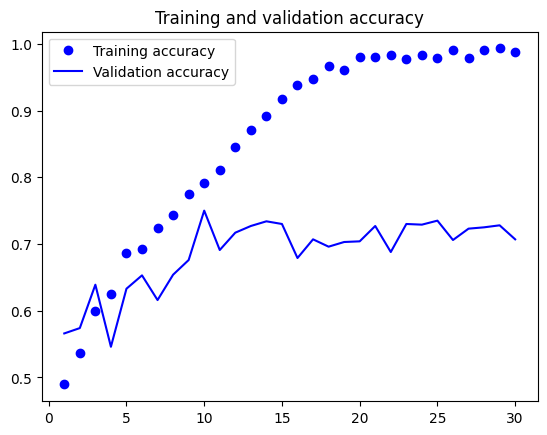

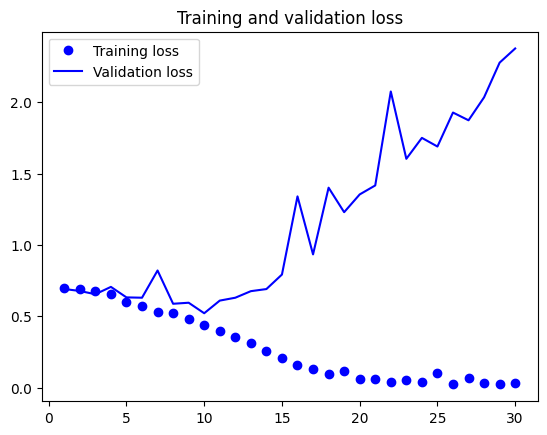

In [32]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy)+1)
plt.plot(epochs, accuracy, "bo", label = "Training accuracy")
plt.plot(epochs, val_accuracy, "b", label = "Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [34]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test acccuracy: {test_acc}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7268 - loss: 0.5589
Test acccuracy: 0.75
